In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools

from aquaponics import Aquaponics

In [4]:
def run_gridpoint(T, I, disp=False):
    a = Aquaponics('hydroplant', 'hydronitrogen', N0=0, T0=T, I0=I)
    m = a.get_model()

    tf = 45
    steps = tf * 10 + 1
    m.time = np.linspace(0,tf,steps)

    a.dNadd.STATUS = 1
    a.dNadd.DCOST = 1
    a.dNadd.UPPER = 1

    m.Obj(-a.w)
    m.options.MAX_ITER = 1000
    m.options.OTOL = 1
    m.options.RTOL = 1
    m.options.CV_TYPE = 2
    m.options.EV_TYPE = 2

    a.solve(glamdring=True, imode=6, disp=disp)
    
    return m.options.APPSTATUS, -m.options.OBJFCNVAL, m, a

In [5]:
Tmin = 18
Tmax = 30
Tstep = 1
Ts = np.arange(Tmin, Tmax + Tstep, Tstep)
Imin = 4
Imax = 8
Istep = 1
Is = np.arange(Imin, Imax + Istep, Istep)
exps = list(itertools.product(Ts, Is))
print('Number of T\'s: {}'.format(len(Ts)))
print('Number of I\'s: {}'.format(len(Is)))
print('Number of Experiments: {}'.format(len(exps)))
print('----')

rs = {}
for i, exp in enumerate(exps):
    T = exp[0]
    I = exp[1]
    sys.stdout.write('\rRunning T={:.1f}, I={:.1f} ({}/{})'.format(T, I, i + 1, len(exps)))
    
    status, obj, m, a = run_gridpoint(T, I * 1e6, disp=False)
    if status == 1:
        sub = rs.get(T, {})
        sub[I] = obj
        rs[T] = sub
    
print('\nDone')

Number of T's: 13
Number of I's: 5
Number of Experiments: 65
----
Running T=30.0, I=8.0 (65/65)
Done


In [6]:
grid = np.zeros((len(Ts), len(Is)))
for Ti, T in enumerate(Ts):
    for Ii, I in enumerate(Is):
        grid[Ti, Ii] = rs.get(T, {}).get(I, 0)   

print(grid)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


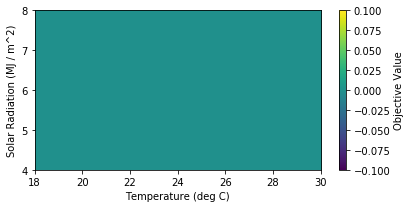

In [7]:
plt.figure(figsize=(6,3))
im = plt.imshow(grid.T, extent=[Tmin, Tmax, Imin, Imax], origin='lower')
ax = plt.gca()
ax.set_aspect('auto')
cb = plt.colorbar(im, ax=ax)
cb.set_label('Objective Value')
plt.ylabel('Solar Radiation (MJ / m^2)')
plt.xlabel('Temperature (deg C)')
plt.tight_layout(h_pad=1)